In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn

In [3]:
# set some seaborn aesthetics
sbn.set_palette("Set1")

In [4]:
# initialize random seed for reproducibility
np.random.seed(20160404)

In [5]:
## simulate one way ANOVA under the null hypothesis of no 
## difference in group means

groupmeans = [0, 0, 0, 0]
k = len(groupmeans) # number of groups
groupstds = [1] * k  # standard deviations equal across groups
n = 25 # sample size

# generate samples
samples = [stats.norm.rvs(loc=i, scale=j, size = n) for (i,j) in zip(groupmeans,groupstds)]
allobs = np.concatenate(samples)

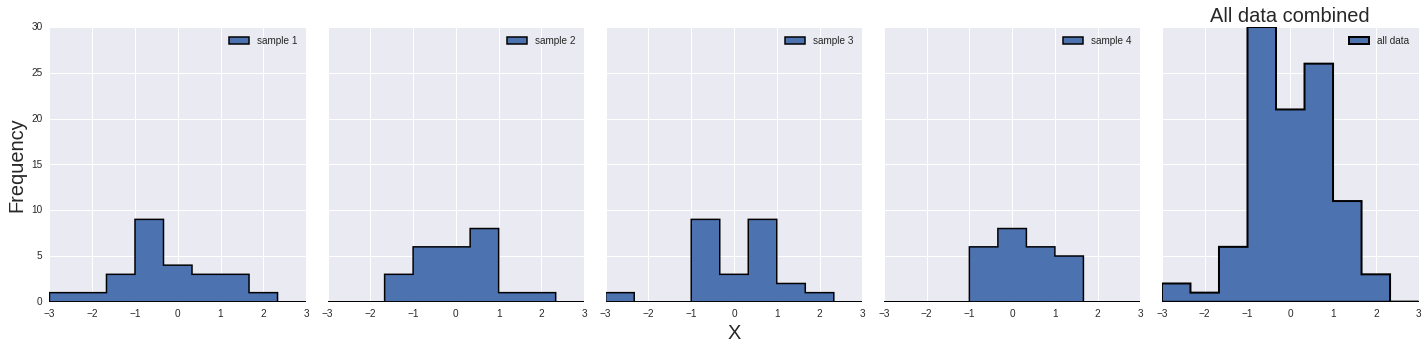

In [6]:
sbn.set_palette("deep")

bins = np.linspace(-3, 3, 10)
fig, axes = plt.subplots(1, 5, figsize=(20,5), sharex=True, sharey=True)

for i, sample in enumerate(samples):
    axes[i].hist(sample, bins=bins, histtype='stepfilled', 
                 linewidth=1.5, label='sample {}'.format(i+1))
    axes[i].legend()

axes[-1].hist(allobs, bins=bins, histtype='stepfilled', linewidth=2, label='all data')
axes[-1].legend()
axes[-1].set_title("All data combined", fontsize=20)

axes[0].set_ylabel("Frequency", fontsize=20)
axes[2].set_xlabel("X", fontsize=20)

fig.tight_layout()
pass

In [7]:
## simulate one way ANOVA under HA

groupmeans = [0, 0, -1, 1]
k = len(groupmeans) # number of groups
groupstds = [1] * k  # standard deviations equal across groups
n = 25 # sample size

# generate samples
samples = [stats.norm.rvs(loc=i, scale=j, size = n) for (i,j) in zip(groupmeans,groupstds)]
allobs = np.concatenate(samples)

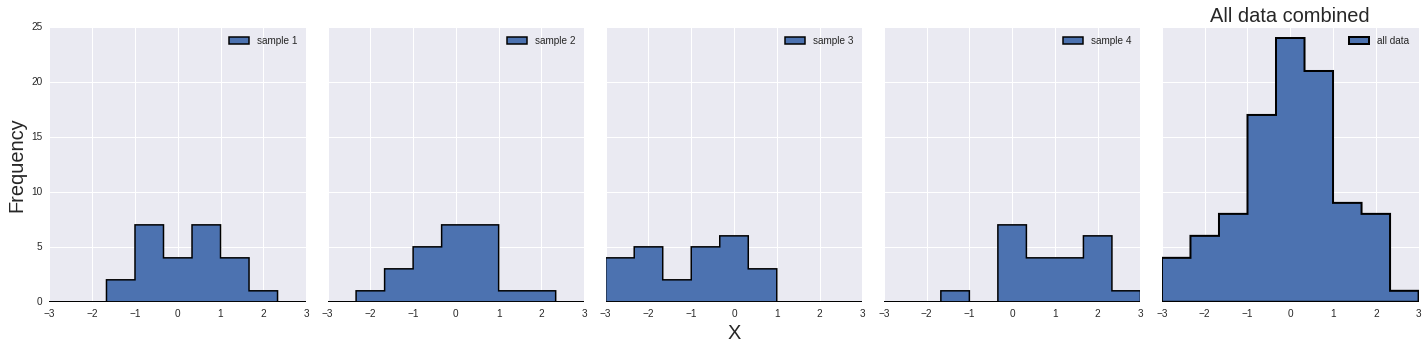

In [8]:
sbn.set_palette("deep")

bins = np.linspace(-3, 3, 10)
fig, axes = plt.subplots(1, 5, figsize=(20,5), sharex=True, sharey=True)

for i, sample in enumerate(samples):
    axes[i].hist(sample, bins=bins, histtype='stepfilled', 
                 linewidth=1.5, label='sample {}'.format(i+1))
    axes[i].legend()

axes[-1].hist(allobs, bins=bins, histtype='stepfilled', linewidth=2, label='all data')
axes[-1].legend()
axes[-1].set_title("All data combined", fontsize=20)

axes[0].set_ylabel("Frequency", fontsize=20)
axes[2].set_xlabel("X", fontsize=20)

fig.tight_layout()
pass